# 正式版代码在最后，中间的代码是测试，会`imshow()`一些图片

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.rcParams['figure.figsize'] = [20,10]    # 设置显示窗口大小

img_1 = cv2.imread('stair-1.png')    # 加载图片
img_2 = cv2.imread('stair-2.png')

img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)

def show(pic_1, pic_2, msg_1 ="Test_1", msg_2 = "Test_2"):
    # 显示图片
    plt.subplot(121);\
        plt.title(msg_1); plt.xticks([]); plt.yticks([]); plt.imshow(pic_1, cmap = 'gray')
    plt.subplot(122);\
        plt.title(msg_2); plt.xticks([]); plt.yticks([]); plt.imshow(pic_2, cmap = 'gray')
    plt.show()

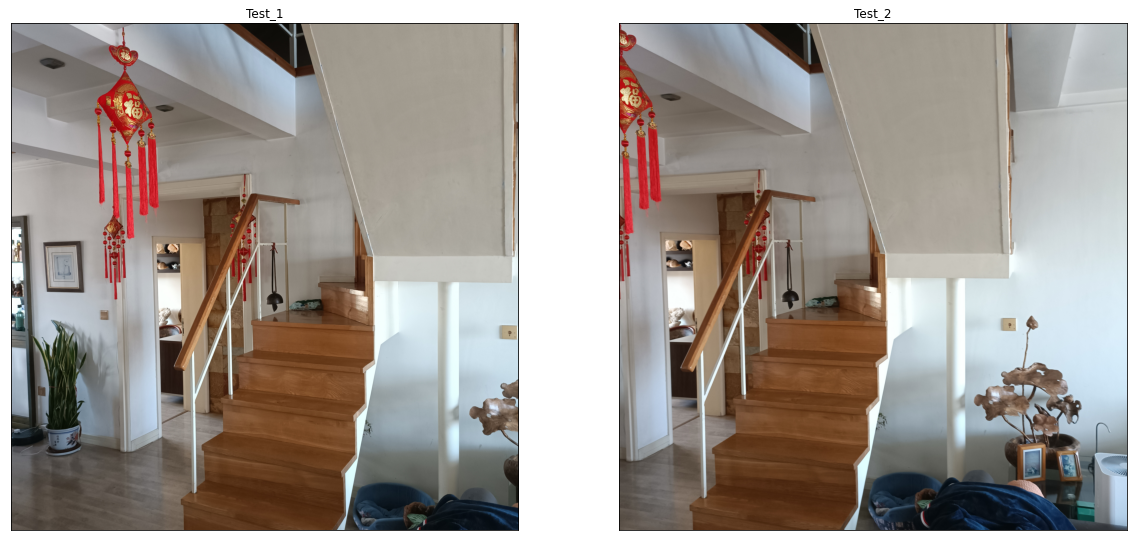

In [3]:
show(img_1, img_2)

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def draw(img_gray, i, j):                                                         #    0 1 2 3 4 5 6
    img_gray[i-3][j-1] = 255; img_gray[i-3][ j ] = 255; img_gray[i-3][j+1] = 255; #  0 □ □ ■ ⊟ ■ □ □
    img_gray[i-2][j-2] = 255;                img_gray[i-2][j+2] = 255;            #  1 □ ■ □ □ □ ■ □
    img_gray[i-1][j-3] = 255;                img_gray[i-1][j+3] = 255;            #  2 ■ □ □ □ □ □ ■
    img_gray[ i ][j-3] = 255;                img_gray[ i ][j+3] = 255;            #  3 ⊠ □ □ p □ □ ⊠
    img_gray[i+1][j-3] = 255;                img_gray[i+1][j+3] = 255;            #  4 ■ □ □ □ □ □ ■
    img_gray[i+2][j-2] = 255;                img_gray[i+2][j+2] = 255;            #  5 □ ■ □ □ □ ■ □
    img_gray[i+3][j-1] = 255; img_gray[i+3][ j ] = 255; img_gray[i+3][j+1] = 255; #  6 □ □ ■ ⊟ ■ □ □

def my_FAST( pic_RGB, test_mode = None ):
    win_size = 10 # 非极大值抑制 窗口大小
    count_Features = 0
    count_Total = 0
    
    if test_mode is True:
        img_color = pic_RGB.copy()    # 不改变原图，复制一个RGB图
        img_ori = pic_RGB.copy()
    img_gray = cv2.cvtColor(pic_RGB, cv2.COLOR_RGB2GRAY)
    row, col, dim = pic_RGB.shape
    scores = np.zeros((row, col))

    for i in range(3, row - 3):
        for j in range(3, col - 3):
            p = img_gray.item(i, j)    # 像素值
            
            # Step 1 : 获得以 p 为中心 半径为3 的圆上的 16 个临近点, 存入 Pn 中
            pn = np.array([                                  #    0 1 2 3 4 5 6
                img_gray[i-3][j-1], img_gray[i-3][ j ], img_gray[i-3][j+1], #  0 □ □ ■ ⊟ ■ □ □
                img_gray[i-2][j-2],                img_gray[i-2][j+2],      #  1 □ ■ □ □ □ ■ □
                img_gray[i-1][j-3],                img_gray[i-1][j+3],      #  2 ■ □ □ □ □ □ ■
                img_gray[ i ][j-3],                img_gray[ i ][j+3],      #  3 ⊠ □ □ p □ □ ⊠
                img_gray[i+1][j-3],                img_gray[i+1][j+3],      #  4 ■ □ □ □ □ □ ■
                img_gray[i+2][j-2],                img_gray[i+2][j+2],      #  5 □ ■ □ □ □ ■ □
                img_gray[i+3][j-1], img_gray[i+3][ j ], img_gray[i+3][j+1], #  6 □ □ ■ ⊟ ■ □ □
            ])
            
            # Step 2 : 定义阈值 t, 计算 直径上某两个点与中心的像素差，若绝对值小于阈值，pass
            #。         否则把该点当作候选点。
            # 直径上的两个点：img[ i ][j-3], img[ i ][j+3]
            t = np.multiply(p, 0.3)
            # p * 0.3    # 阈值
            if np.abs(int(pn[7]) - p) < t and np.abs(int(pn[8]) - p) < t:    
                continue
                
            # Step 3 : FAST-9 要求连续的 9 个点
            p_1_5_9_13 = np.array([
                np.abs(int(pn[ 7]) - p) > t,    # ⊟ [ 7] i  , j-3
                np.abs(int(pn[ 1]) - p) > t,    # ⊟ [ 1] i-3, j
                np.abs(int(pn[ 8]) - p) > t,    # ⊟ [ 8] i  , j+3
                np.abs(int(pn[14]) - p) > t     # ⊟ [14] i+3, j 
                ])
            #print(p_1_5_9_13)
            #if p_1_5_9_13.count(True) >= 3:
            if np.count_nonzero(p_1_5_9_13 == True) >= 3:
                ind = np.array( [ np.abs(pn - p) > t ] )
                if np.count_nonzero(ind[0] == True) >= 9:
                    # Step 4 : 赋值 scores 数组
                    scores[i][j] = np.sum(np.abs(pn - p))
    """
    # For Test Only
    plt.rcParams['figure.figsize'] = [30,15]
    plt.imshow(scores, cmap='gray')
    return
    """
    # Step 5 : 非极大值抑制
    retVal = np.zeros((row, col))
    for i in range(win_size, row - win_size):
        for j in range(win_size, col - win_size):
            if scores.item(i, j) != 0:
                count_Total += 1
                scores_win = scores[i - win_size : i + win_size, j - win_size : j + win_size]
                if test_mode is True:
                    img_color.itemset((i, j, 2), 0)    # B
                    img_color.itemset((i, j, 1), 255)    # G
                    img_color.itemset((i, j, 0), 0)  # R
                if scores_win.max() == scores.item(i, j):
                    pos = np.unravel_index(np.argmax(scores_win),scores_win.shape)
                    count_Features += 1
                    retVal.itemset((i, j), 255)
                    """
                    if test_mode is True:
                        cv2.circle(img_gray, (i, j), int(win_size), 255, 3)
                        img_gray.itemset((i, j), 255)
                    """
                    
                # if scores.max() == scores[i][j]:
                    
    if test_mode is True:                
        plt.rcParams['figure.figsize'] = [20, 20]
        print("特征点个数为：", count_Total)
        print("极大值抑制窗口大小：", win_size)
        print("极大值抑制剩余特征：", count_Features)

        plt.subplot(221)
        plt.title("All Features");
        plt.imshow(img_color); plt.axis('off')

        plt.subplot(222)
        plt.imshow(retVal, cmap='gray'); plt.axis('off')
        plt.title("Non-Maximum Suppression")

        plt.subplot(223)
        temp = img_gray.copy()
        for i in range(row):
            for j in range(col):
                if retVal.item(i, j) == 255:
                    draw(img_gray, i, j)
        img_merge = cv2.merge((temp, img_gray, temp))
        plt.imshow(img_merge, cmap='gray'); plt.axis('off')
        title_str = "Windows size = " + str(win_size)
        plt.title(title_str)
        
        plt.subplot(224)
        plt.imshow(scores, cmap='gray'); plt.axis('off')
        plt.title("All Features")
        plt.tight_layout()
    return retVal

特征点个数为： 45913
极大值抑制窗口大小： 10
极大值抑制剩余特征： 939


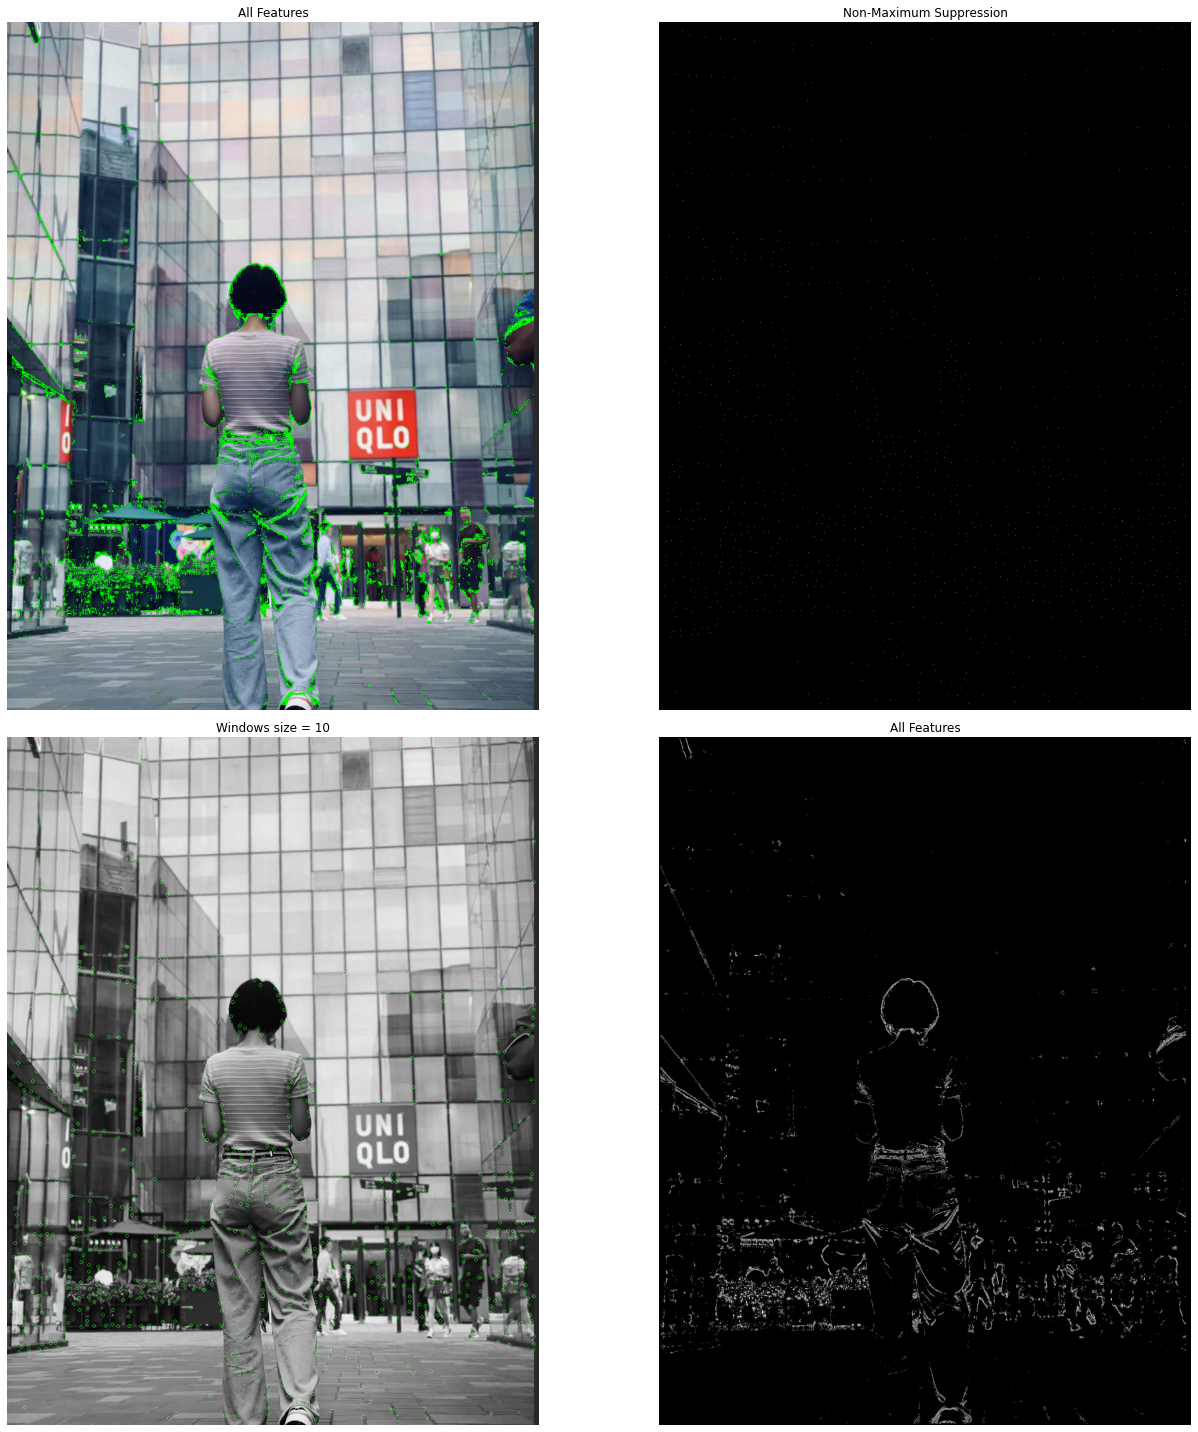

In [31]:
#img = cv2.imread('stair-1.png')    # Cloud Test
img = cv2.imread('test.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ret = my_FAST(img, test_mode=True)

In [32]:
#img = cv2.imread('stair-1.png')    # Cloud Test
img = cv2.imread('lena.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#ret = my_FAST(img, test_mode=True)

特征点个数为： 33391
极大值抑制窗口大小： 10
极大值抑制剩余特征： 204


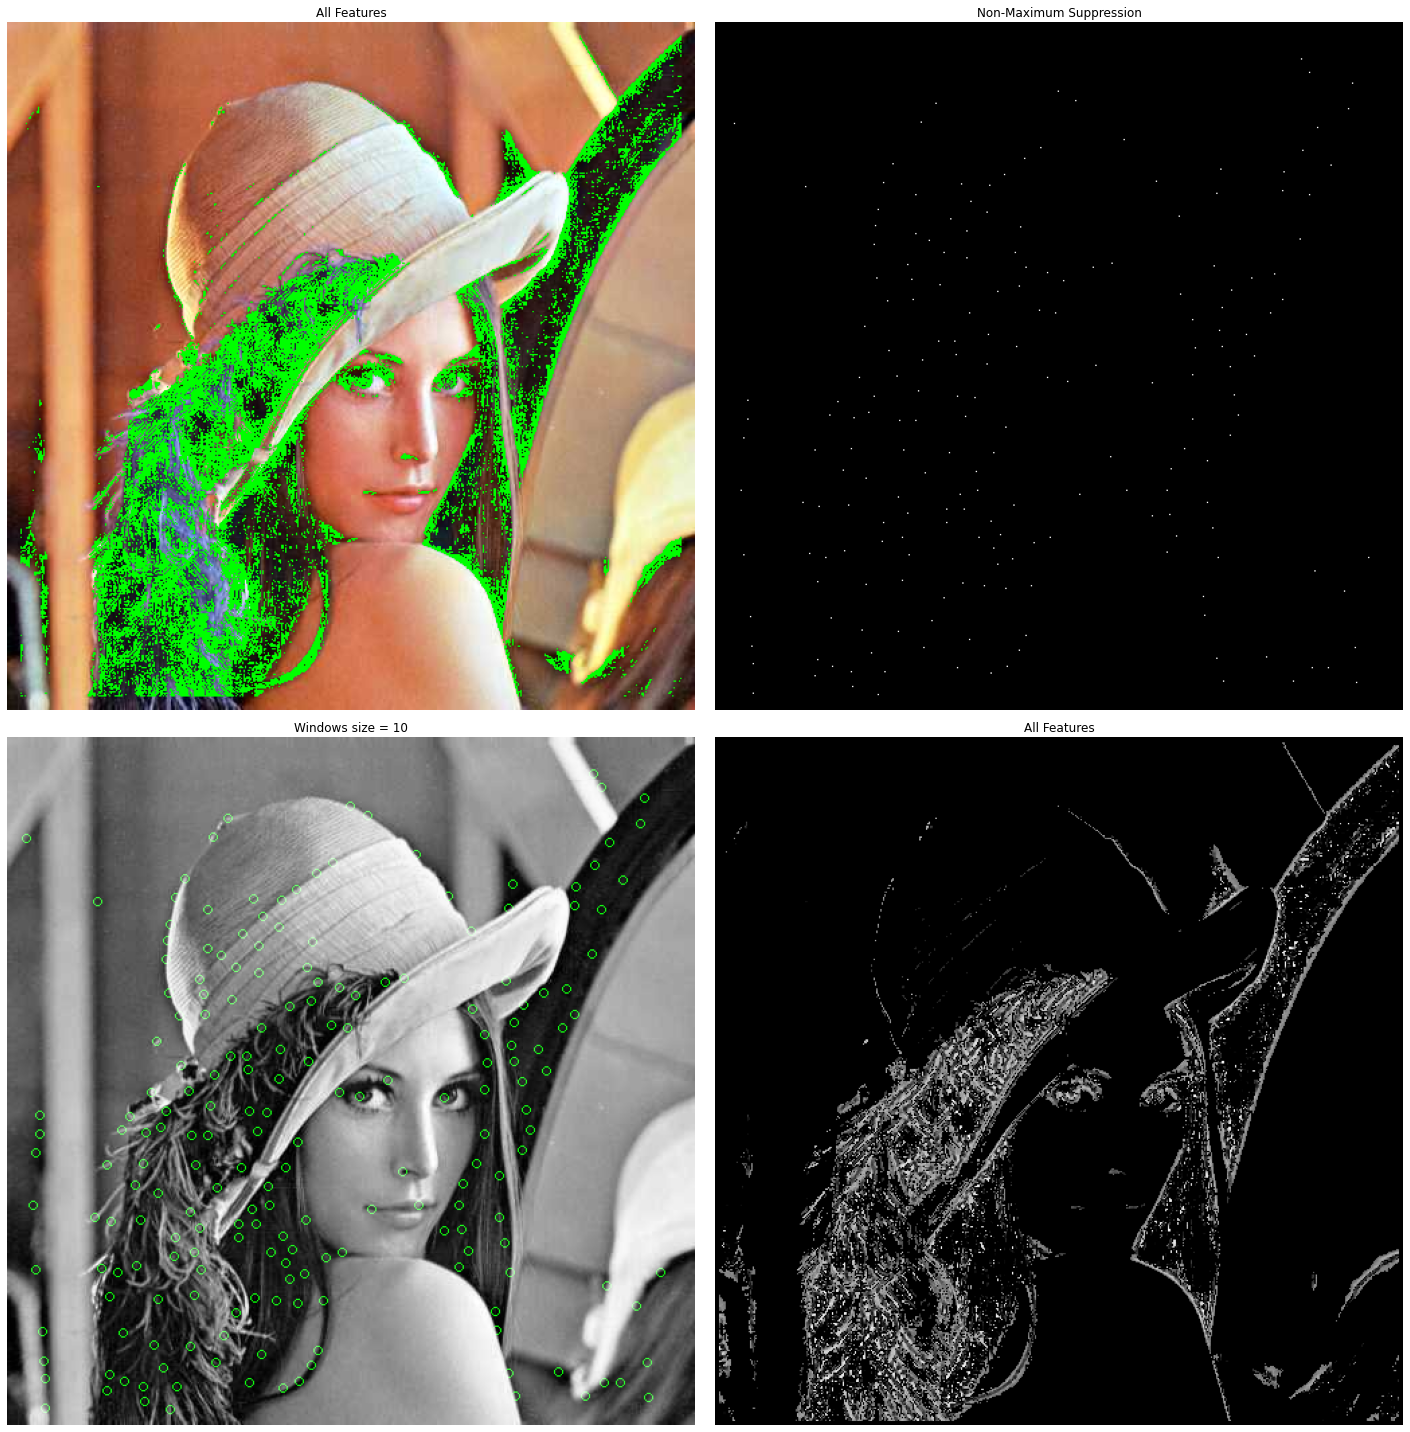

In [33]:
ret = my_FAST(img, test_mode=True)

In [34]:
my_FAST(img, test_mode = None)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

特征点个数为： 54280
极大值抑制窗口大小： 10
极大值抑制剩余特征： 1953


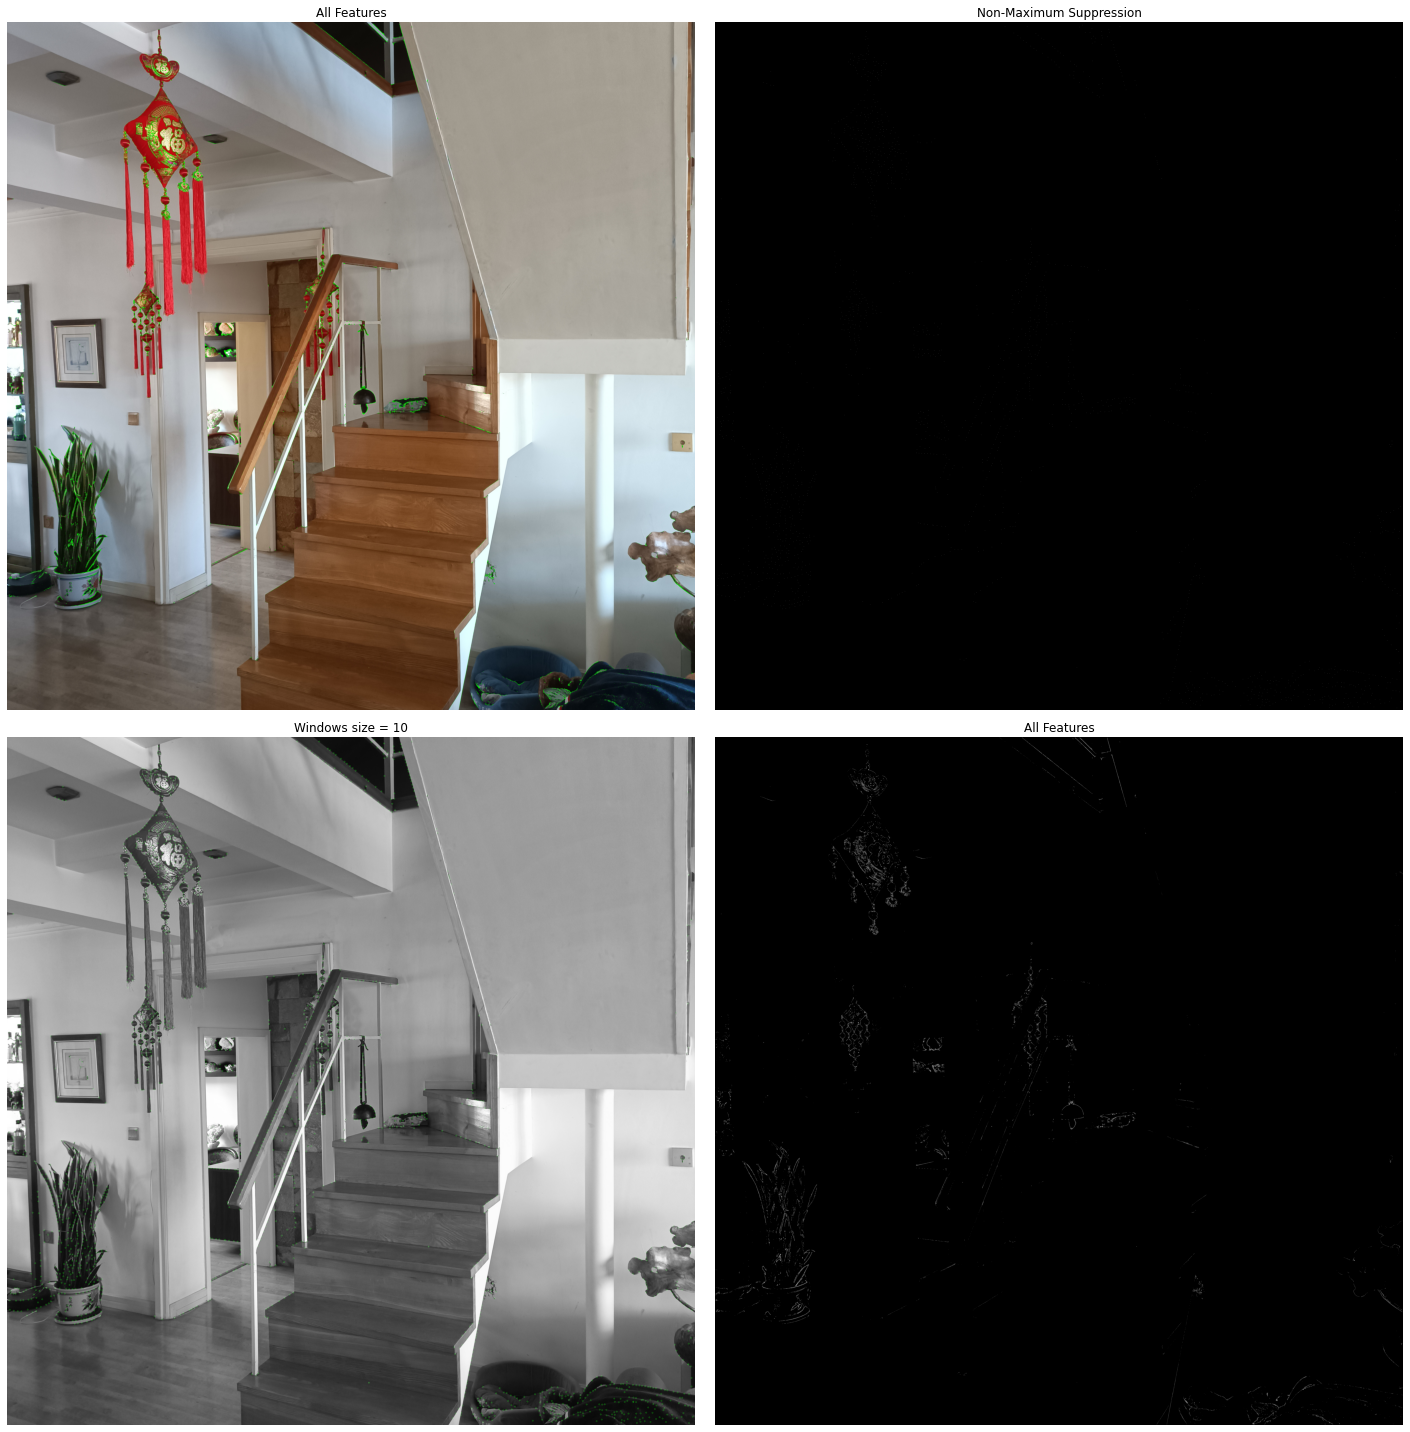

In [35]:
sc_1 = my_FAST(img_1, test_mode=True)

特征点个数为： 29847
极大值抑制窗口大小： 10
极大值抑制剩余特征： 1212


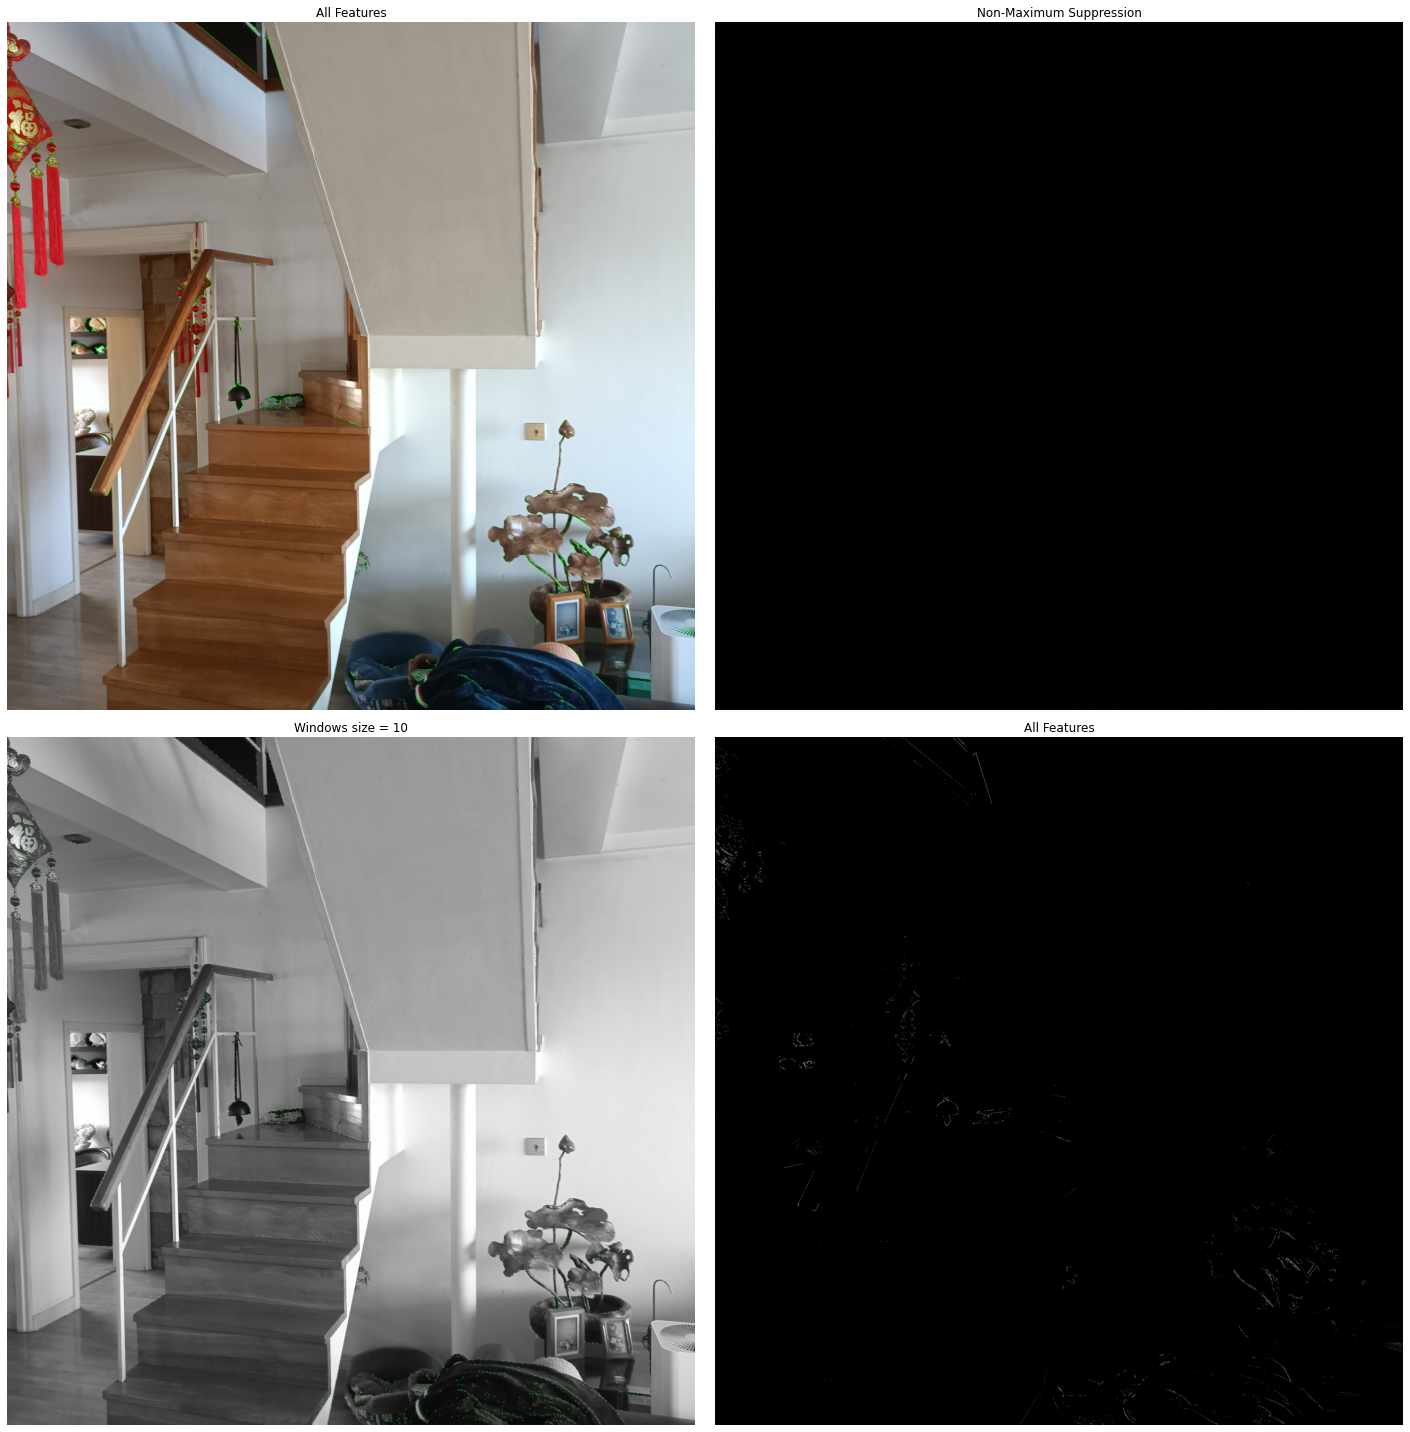

In [36]:
sc_2 = my_FAST(img_2, test_mode=True)

23


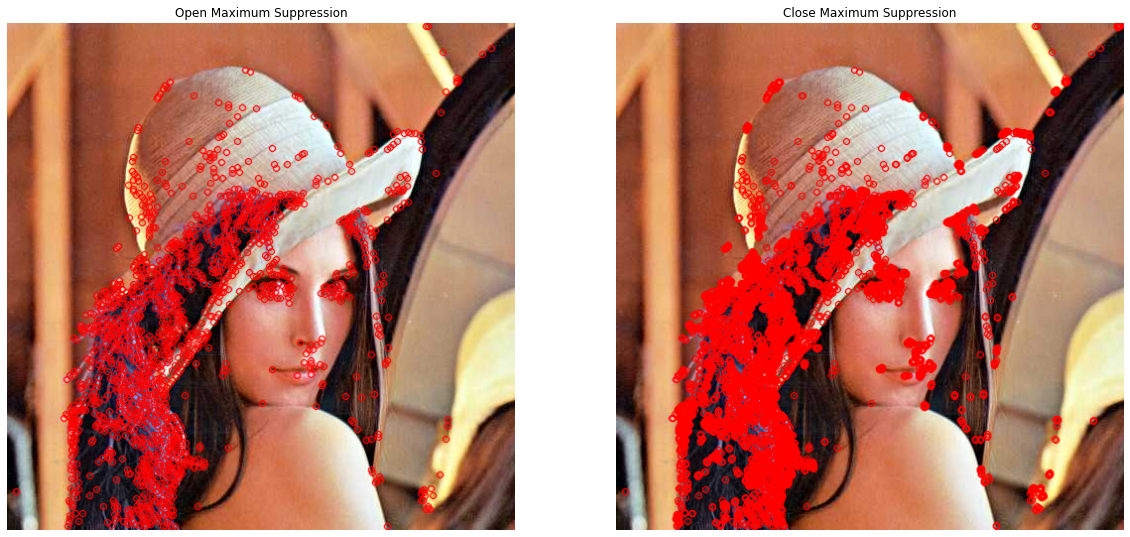

In [37]:
# OFFICIAL FAST
th = int(np.average(img) * 0.2)
print(th)
# 使用默认值初始化FAST对象
fast = cv2.FastFeatureDetector_create(threshold = th, type=cv2.FAST_FEATURE_DETECTOR_TYPE_9_16)
# 寻找和画出关键点
kp = fast.detect(img, None)
img2 = cv2.drawKeypoints(img, kp, None, color=(255, 0, 0))
 
# 关闭非极大值抑制
fast.setNonmaxSuppression(False)
kp = fast.detect(img, None)
 
img3 = cv2.drawKeypoints(img, kp, None, color=(255, 0, 0))

plt.subplot(121), plt.imshow(img2),
plt.title('Open Maximum Suppression'), plt.axis('off')
plt.subplot(122), plt.imshow(img3),
plt.title('Close Maximum Suppression'), plt.axis('off')
plt.show()

35


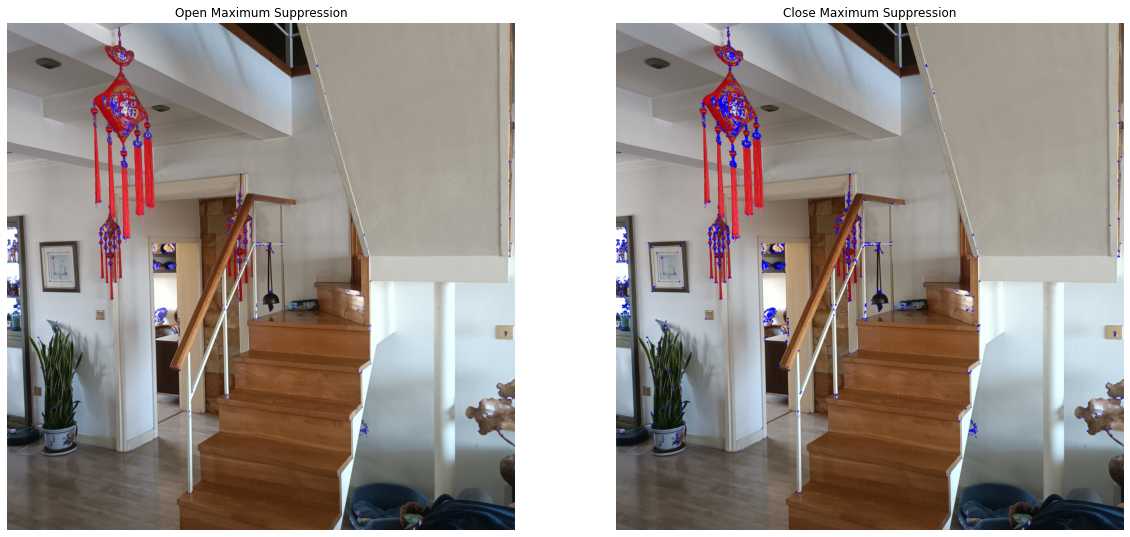

In [38]:
# OFFICIAL FAST
th = int(np.average(img) * 0.3)
print(th)
# 使用默认值初始化FAST对象
fast = cv2.FastFeatureDetector_create(threshold = th, type = cv2.FAST_FEATURE_DETECTOR_TYPE_9_16)
# 寻找和画出关键点
kp_1 = fast.detect(img_1, None)
img2 = cv2.drawKeypoints(img_1, kp_1, None, color = (0, 0, 255))
 
# 关闭非极大值抑制
fast.setNonmaxSuppression(False)
kp_2 = fast.detect(img_1, None)
 
img3 = cv2.drawKeypoints(img_1, kp_2, None, color = (0, 0, 255))

plt.subplot(121), plt.imshow(img2),
plt.title('Open Maximum Suppression'), plt.axis('off')
plt.subplot(122), plt.imshow(img3),
plt.title('Close Maximum Suppression'), plt.axis('off')
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def draw(img_gray, i, j):                                                         #    0 1 2 3 4 5 6
    img_gray[i-3][j-1] = 255; img_gray[i-3][ j ] = 255; img_gray[i-3][j+1] = 255; #  0 □ □ ■ ⊟ ■ □ □
    img_gray[i-2][j-2] = 255;                img_gray[i-2][j+2] = 255;            #  1 □ ■ □ □ □ ■ □
    img_gray[i-1][j-3] = 255;                img_gray[i-1][j+3] = 255;            #  2 ■ □ □ □ □ □ ■
    img_gray[ i ][j-3] = 255;                img_gray[ i ][j+3] = 255;            #  3 ⊠ □ □ p □ □ ⊠
    img_gray[i+1][j-3] = 255;                img_gray[i+1][j+3] = 255;            #  4 ■ □ □ □ □ □ ■
    img_gray[i+2][j-2] = 255;                img_gray[i+2][j+2] = 255;            #  5 □ ■ □ □ □ ■ □
    img_gray[i+3][j-1] = 255; img_gray[i+3][ j ] = 255; img_gray[i+3][j+1] = 255; #  6 □ □ ■ ⊟ ■ □ □

def my_FAST( pic_RGB ):
    win_size = 10 
    img_gray = cv2.cvtColor(pic_RGB, cv2.COLOR_RGB2GRAY)
    row, col, dim = pic_RGB.shape
    scores = np.zeros((row, col))
    for i in range(3, row - 3):
        for j in range(3, col - 3):
            p = img_gray.item(i, j) 
            pn = np.array([                                                 #    0 1 2 3 4 5 6
                img_gray[i-3][j-1], img_gray[i-3][ j ], img_gray[i-3][j+1], #  0 □ □ ■ ⊟ ■ □ □
                img_gray[i-2][j-2],                img_gray[i-2][j+2],      #  1 □ ■ □ □ □ ■ □
                img_gray[i-1][j-3],                img_gray[i-1][j+3],      #  2 ■ □ □ □ □ □ ■
                img_gray[ i ][j-3],                img_gray[ i ][j+3],      #  3 ⊠ □ □ p □ □ ⊠
                img_gray[i+1][j-3],                img_gray[i+1][j+3],      #  4 ■ □ □ □ □ □ ■
                img_gray[i+2][j-2],                img_gray[i+2][j+2],      #  5 □ ■ □ □ □ ■ □
                img_gray[i+3][j-1], img_gray[i+3][ j ], img_gray[i+3][j+1], #  6 □ □ ■ ⊟ ■ □ □
            ])
            t = np.multiply(p, 0.3)
            if np.abs(int(pn[7]) - p) < t and np.abs(int(pn[8]) - p) < t:    
                continue
            p_1_5_9_13 = np.array([
                np.abs(int(pn[ 7]) - p) > t,    # ⊟ [ 7] i  , j-3
                np.abs(int(pn[ 1]) - p) > t,    # ⊟ [ 1] i-3, j
                np.abs(int(pn[ 8]) - p) > t,    # ⊟ [ 8] i  , j+3
                np.abs(int(pn[14]) - p) > t     # ⊟ [14] i+3, j 
                ])
            if np.count_nonzero(p_1_5_9_13 == True) >= 3:
                ind = np.array( [ np.abs(pn - p) > t ] )
                if np.count_nonzero(ind[0] == True) >= 9:
                    scores[i][j] = np.sum(np.abs(pn - p))
    retVal = np.zeros((row, col))
    for i in range(win_size, row - win_size):
        for j in range(win_size, col - win_size):
            if scores.item(i, j) != 0:
                scores_win = scores[i - win_size : i + win_size, j - win_size : j + win_size]
                if scores_win.max() == scores.item(i, j):
                    pos = np.unravel_index(np.argmax(scores_win),scores_win.shape)
                    retVal.itemset((i, j), 255)
    return retVal